# Fragment analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd

from util import *

RDKit WARNING: [17:24:19] Enabling RDKit 2019.09.3 jupyter extensions


## Load fragment library

In [3]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

In [4]:
# Get fragment library by subpocket
fragment_library = read_fragment_library(PATH_TO_LIB)

for subpocket, fragments in fragment_library.items():
    fragments['subpocket'] = subpocket

In [5]:
print(fragment_library.keys())
print(f'Example fragments for subpocket AP:')

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])
Example fragments for subpocket AP:


In [6]:
# Merge all subpockets
fragment_library_concat = pd.concat(fragment_library)
fragment_library_concat.reset_index(drop=True, inplace=True)

In [7]:
type(fragment_library_concat.fragment[0])

rdkit.Chem.rdchem.Mol

In [8]:
# Remove pool X
fragment_library_concat_wo_x = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()

## Fragment library overview

In [9]:
# Number of fragments in all fragment subpocket pools
n_fragments = fragment_library_concat.shape[0]

# Number of fragments in all fragment subpocket pools except pool X
n_fragments_wo_x = fragment_library_concat_wo_x.shape[0]

print(f'Number of fragments in library: {n_fragments}')
print(f'Number of fragments in library without pool X: {n_fragments_wo_x}')

Number of fragments in library: 7486
Number of fragments in library without pool X: 7201


In [10]:
# Deduplicate these strings in order to get the number of ligands from which the fragments originate
n_original_ligands = fragment_library_concat.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size().shape[0]

print(f'Number of original ligands (from which fragments originate): {n_original_ligands}')

Number of original ligands (from which fragments originate): 2553


## Number of subpockets occupied by a ligand

Ligands can occupy subpocket(s) multiple times. Let's check how often this happens for which subpockets.

In [11]:
n_fragments_per_subpocket_per_ligand = fragment_library_concat_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).size()
n_fragments_per_subpocket_per_ligand = n_fragments_per_subpocket_per_ligand.reset_index()
n_fragments_per_subpocket_per_ligand.rename(columns={0: 'n_fragments'}, inplace=True)

How often does a ligand occupy a subpocket mulitple times? And how many times?

In [12]:
n_fragments_per_subpocket_per_ligand.groupby('n_fragments').size()

n_fragments
1    6948
2     125
3       1
dtype: int64

Which subpockets are occupied how often by multiple fragments per ligand?

In [13]:
n_fragments_per_subpocket_per_ligand[
    n_fragments_per_subpocket_per_ligand.n_fragments > 1
].groupby('subpocket').size()

subpocket
AP     8
B1     1
FP    95
GA     2
SE    20
dtype: int64

In order to calculate the number of subpockets a ligand is occupying, it is not of interest how often a subpocket is occupied by a ligand. Thus, we keep only one entry per ligand and subpocket.

In [14]:
n_subpockets_per_ligand = fragment_library_concat_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).first().reset_index().groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size()

In [15]:
n_subpockets_per_ligand_distribution = pd.concat(
    [
        n_subpockets_per_ligand.value_counts().sort_index().rename('ligand_count'), 
        n_subpockets_per_ligand.value_counts(normalize=True).sort_index().rename('ligand_frequency')*100
    ],
    axis=1
)

In [16]:
print('Number of subpockets per ligand (distribution):')
n_subpockets_per_ligand_distribution

Number of subpockets per ligand (distribution):


,ligand_count,ligand_frequency
1,127,4.974540
2,719,28.162946
3,1350,52.878966
4,327,12.808461
5,29,1.135919
6,1,0.039170


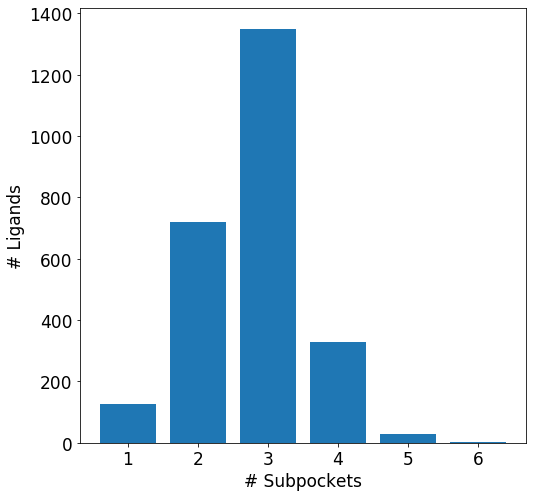

In [17]:
plot_n_subpockets(n_subpockets_per_ligand_distribution)

### Examples for ligands occupying 6 subpockets

In [18]:
ligand_of_interest_six = n_subpockets_per_ligand[n_subpockets_per_ligand == 6].reset_index()
ligand_of_interest_six

,kinase,complex_pdb,ligand_pdb,0
0,ALK,4fnz,NZF,6


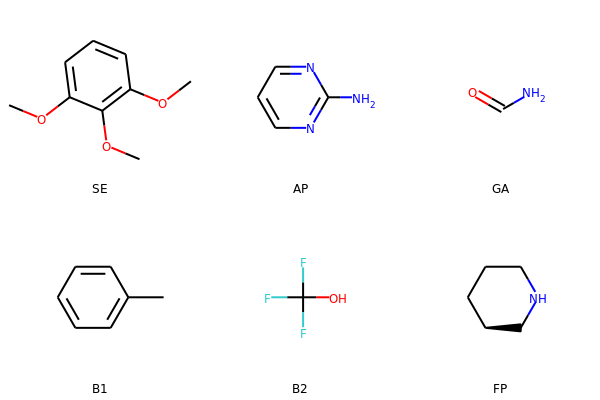

In [19]:
image_six_subpockets = draw_fragmented_ligand(
    fragment_library, 
    ligand_of_interest_six.complex_pdb.values[0], 
    ligand_of_interest_six.ligand_pdb.values[0],
    mols_per_row=3
)
image_six_subpockets.save(f'figures/extreme_subpockets_six_fragments.png')
image_six_subpockets

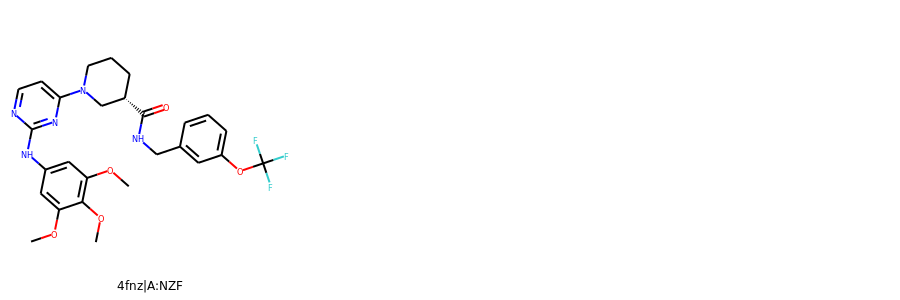

In [20]:
pdb_ids = ['4fnz']
image_ligand_from_pdb_ids = draw_ligands_from_pdb_ids(pdb_ids, sub_img_size=(300,300))
image_ligand_from_pdb_ids.save(f'figures/extreme_subpockets_six_ligand.png')
image_ligand_from_pdb_ids

### Unfragmented ligands

In [21]:
ligand_of_interest_one = n_subpockets_per_ligand[n_subpockets_per_ligand == 1].reset_index()

In [22]:
unfragmented_ligands = []

for index, row in ligand_of_interest_one.iterrows():
    
    unfragmented_ligands.append(
        get_fragmented_ligand(
            fragment_library, 
            row.complex_pdb, 
            row.ligand_pdb
        )
    )
    
unfragmented_ligands = pd.concat(unfragmented_ligands)

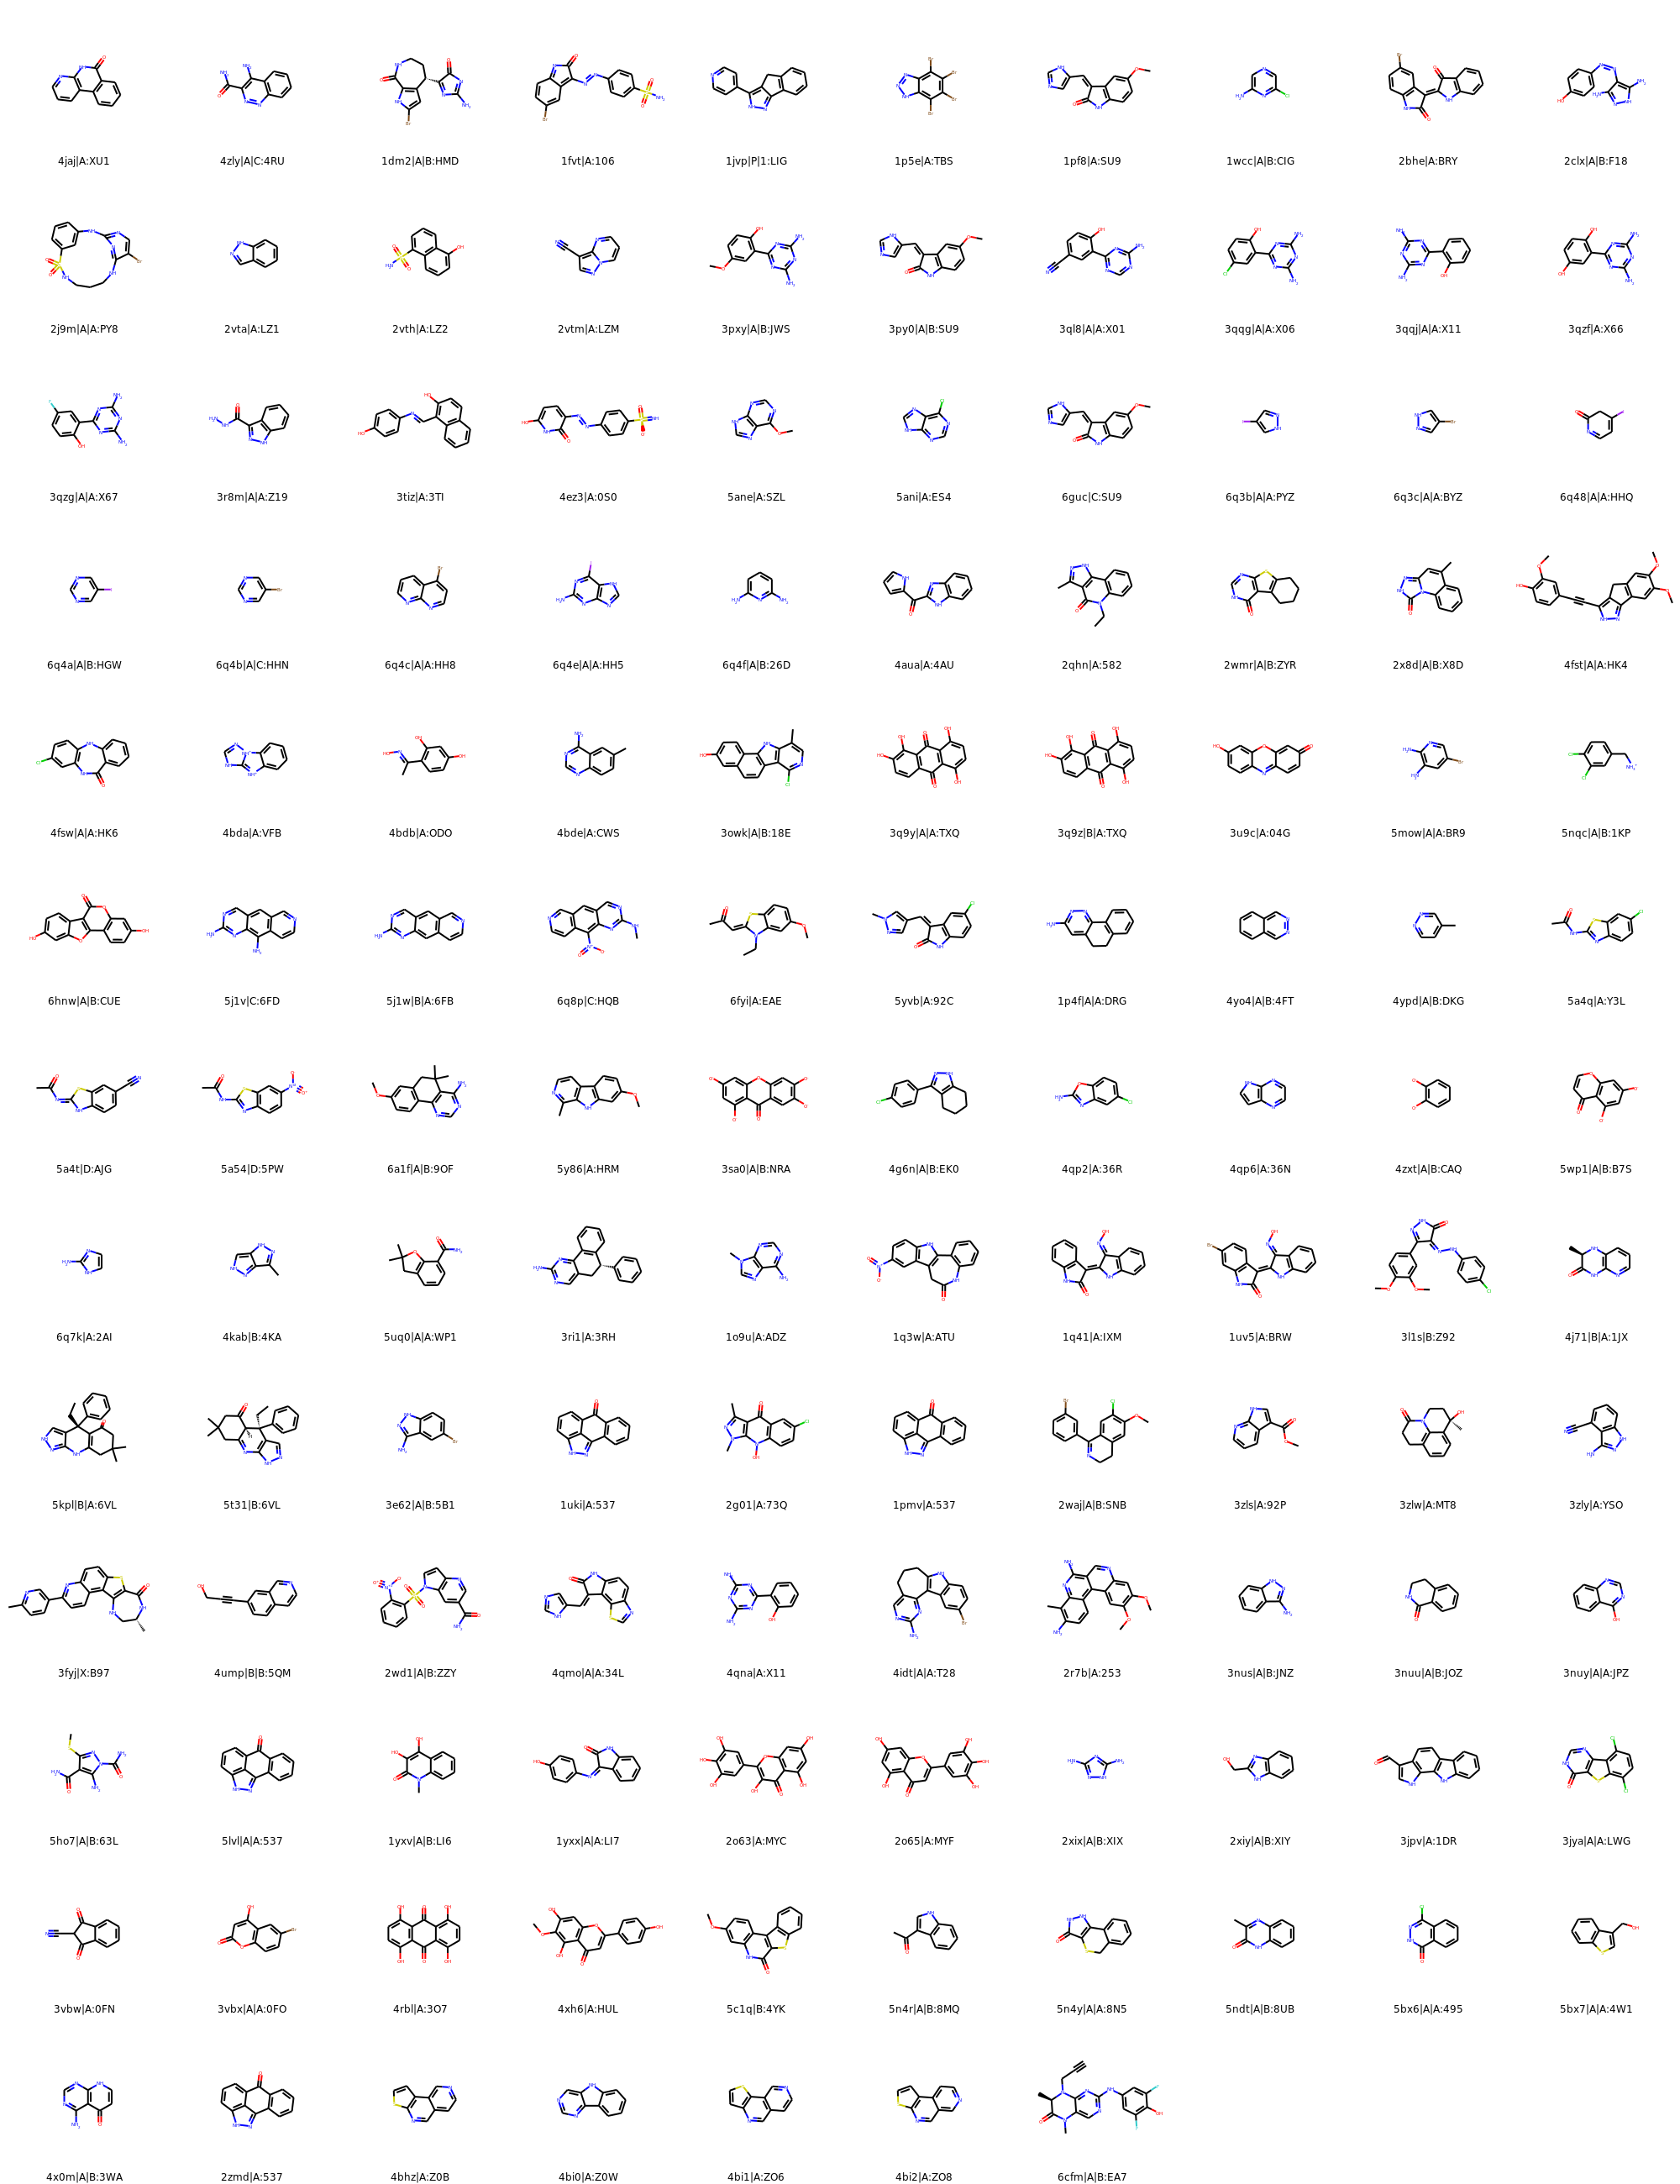

In [23]:
image_unfragmented = draw_fragments(unfragmented_ligands, mols_per_row=10)
image_unfragmented.save(f'figures/extreme_subpockets_one.png')
image_unfragmented

### Examples for unfragmented ligands in paper

In [24]:
# Supplement figure with subfigures B1-B8, C1-C3, D1-D3
unfragmented_ligands_paper_b = [
    ['6q3b', 'PYZ'], 
    ['6q3c', 'BYZ'], 
    ['6q48', 'HHQ'],
    ['6q4a', 'HGW'],
    ['6q4b', 'HHN'], 
    ['6q4c', 'HH8'],
    ['6q4e', 'HH5'],
    ['6q4f', '26D']
]
unfragmented_ligands_paper_c = [
    ['3q9y', 'TXQ'],
    ['5j1w', '6FB'],
    ['2o63', 'MYC']
]
unfragmented_ligands_paper_d = [
    ['4fst', 'HK4'],
    ['3fyj', 'B97'],
    ['6cfm', 'EA7']
]

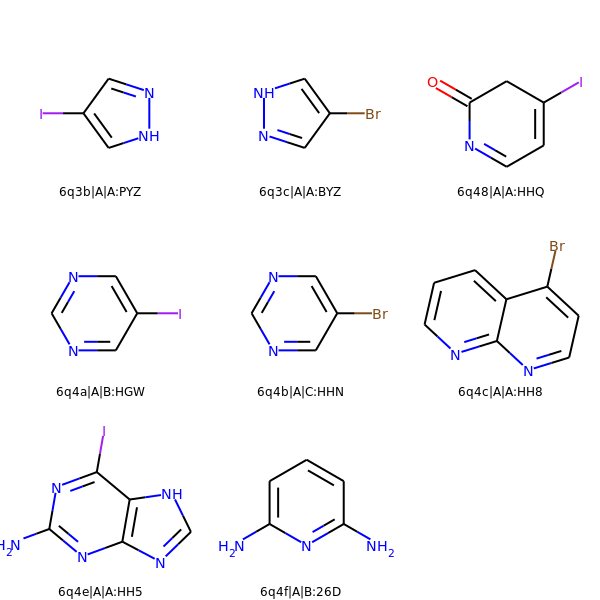

In [25]:
image_unfragmented_paper_b = draw_selected_fragments(
    unfragmented_ligands_paper_b, 
    unfragmented_ligands
)
image_unfragmented_paper_b.save(f'figures/extreme_subpockets_one_paper_b.png')
image_unfragmented_paper_b

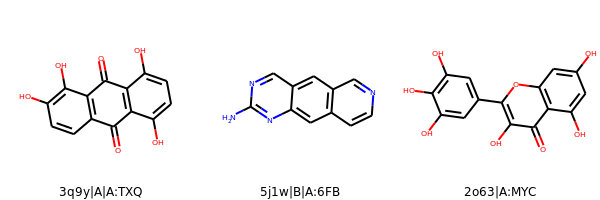

In [26]:
image_unfragmented_paper_c = draw_selected_fragments(
    unfragmented_ligands_paper_c, 
    unfragmented_ligands
)
image_unfragmented_paper_c.save(f'figures/extreme_subpockets_one_paper_c.png')
image_unfragmented_paper_c

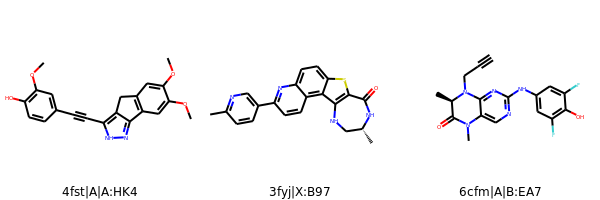

In [27]:
image_unfragmented_paper_d = draw_selected_fragments(
    unfragmented_ligands_paper_d, 
    unfragmented_ligands
)
image_unfragmented_paper_d.save(f'figures/extreme_subpockets_one_paper_d.png')
image_unfragmented_paper_d

## Fragments per subpocket

### Deduplicated fragments (per subpocket)

In [28]:
n_fragments_per_subpocket = [len(fragments) for subpocket, fragments in fragment_library.items()]
n_fragments_per_subpocket_deduplicated = [len(fragments.drop_duplicates('smiles')) for subpocket, fragments in fragment_library.items()]

In [29]:
stats_n_fragments = pd.DataFrame(
    {
        'n_fragments': n_fragments_per_subpocket,
        'n_fragments_deduplicated': n_fragments_per_subpocket_deduplicated,
        'freq_duplicates': [(i-j) / i * 100 for i, j in zip(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)]
    },
    index=fragment_library.keys()
)
stats_n_fragments

,n_fragments,n_fragments_deduplicated,freq_duplicates
AP,2561,1115,56.462319
FP,1866,864,53.697749
SE,1560,607,61.089744
GA,1024,306,70.117188
B1,98,42,57.142857
B2,92,43,53.260870
X,285,110,61.403509


In [30]:
print(f'Mean duplicates frequency across subpockets: {stats_n_fragments.freq_duplicates.mean()}')

Mean duplicates frequency across subpockets: 59.02489073891017


In [31]:
pd.DataFrame(
    {
        'freq_fragments': [i / sum(n_fragments_per_subpocket[:-1]) * 100 for i in n_fragments_per_subpocket[:-1]],
        'freq_fragments_deduplicated': [i / sum(n_fragments_per_subpocket_deduplicated[:-1]) * 100 for i in n_fragments_per_subpocket_deduplicated[:-1]]
    },
    index=list(fragment_library.keys())[:-1]
)

,freq_fragments,freq_fragments_deduplicated
AP,35.564505,37.453813
FP,25.913068,29.022506
SE,21.663658,20.389654
GA,14.220247,10.278804
B1,1.360922,1.410816
B2,1.277600,1.444407


In [32]:
print(f'Number of fragments (wo X): {sum(n_fragments_per_subpocket[:-1])}')
print(f'Number of deduplicated fragments (wo X): {sum(n_fragments_per_subpocket_deduplicated[:-1])}')

Number of fragments (wo X): 7201
Number of deduplicated fragments (wo X): 2977


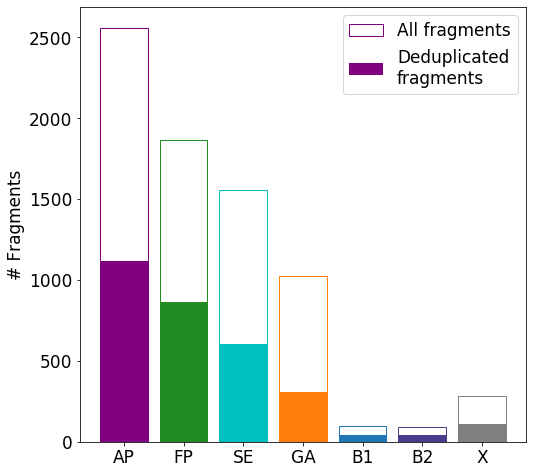

In [33]:
plot_n_fragments_per_subpocket(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)

### Singleton fragments

In [34]:
fragment_occurrence = fragment_library_concat.groupby(['subpocket', 'smiles']).size()
fragment_occurrence.head()

subpocket  smiles                      
AP         Brc1c(Br)c(Br)c2[nH]cnc2c1Br    2
           Brc1c(Br)c(Br)c2[nH]nnc2c1Br    4
           Brc1c(Br)c(Br)c2n[nH]nc2c1Br    2
           Brc1ccc2[nH]ccc2c1              1
           Brc1ccc2occc2c1                 2
dtype: int64

In [35]:
singletons = pd.DataFrame(
    {
        '# singletons': fragment_occurrence[fragment_occurrence == 1].reset_index().groupby('subpocket').size(),
        '# duplicated fragments': fragment_occurrence[fragment_occurrence > 1].reset_index().groupby('subpocket').size(),
        '# deduplicated fragments': fragment_occurrence.reset_index().groupby('subpocket').size()
    }
)
singletons['% singletons'] = singletons['# singletons'] / singletons['# deduplicated fragments'] * 100
singletons

,# singletons,# duplicated fragments,# deduplicated fragments,% singletons
subpocket,,,,
AP,762,353,1115,68.340807
B1,29,13,42,69.047619
B2,27,16,43,62.790698
FP,607,257,864,70.254630
GA,181,125,306,59.150327
SE,397,210,607,65.403624
X,68,42,110,61.818182


In [36]:
print(f"Average ratio of singletons across subpockets: {singletons.drop('X')['% singletons'].mean()}")

Average ratio of singletons across subpockets: 65.8312841176914


### Duplicate fragments

In [37]:
fragment_kinases = fragment_library_concat.groupby(['subpocket', 'smiles'])['kinase'].apply(list)
fragment_kinases.head()

subpocket  smiles                      
AP         Brc1c(Br)c(Br)c2[nH]cnc2c1Br                 [CK2a1, CK2a1]
           Brc1c(Br)c(Br)c2[nH]nnc2c1Br    [CDK2, CK2a1, CK2a2, CK2a2]
           Brc1c(Br)c(Br)c2n[nH]nc2c1Br                 [CK2a1, CK2a1]
           Brc1ccc2[nH]ccc2c1                                   [PIM1]
           Brc1ccc2occc2c1                                [PIM1, PIM1]
Name: kinase, dtype: object

In [38]:
#
fragment_duplicate = fragment_kinases[fragment_kinases.apply(lambda x: len(x) > 1)]
fragment_duplicate_on_single_kinase = fragment_duplicate[fragment_duplicate.apply(lambda x: len(set(x)) == 1)]

print(
    f'Number of duplicate fragments that binding only to one kinase: '
    f'{len(fragment_duplicate_on_single_kinase)}'
)
print(
    f'Ratio of duplicate fragments that binding only to one kinase: '
    f"{len(fragment_duplicate_on_single_kinase) / singletons.drop('X')['# deduplicated fragments'].sum()}"
)

Number of duplicate fragments that binding only to one kinase: 381
Ratio of duplicate fragments that binding only to one kinase: 0.12798118911656028


## Subpocket connections

In [39]:
connections_by_fragment = connections_by_fragment(fragment_library_concat_wo_x)
connections_by_fragment.head()

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name
0,AAK1,5l4q,LKB,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,"[FP, SE]","[AP=FP, AP=SE]"
1,AAK1,5te0,XIN,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, GA]","[AP=SE, AP=GA]"
2,ABL1,2f4j,VX6,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE]
3,ABL1,2gqg,1N1,AP AP AP AP AP AP AP AP AP AP GA SE,"[GA, SE]","[AP=GA, AP=SE]"
4,ABL1,2v7a,627,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, FP]","[AP=SE, AP=FP]"


In [40]:
n_ligands_multiple_fragments_in_subpocket = connections_by_fragment[
    connections_by_fragment.apply(
        lambda x: len(x.connections) != len(set(x.connections)),
        axis=1
    )
].groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size()

print(f'Number of ligands that show multiple fragments in one or more subpockets: {len(n_ligands_multiple_fragments_in_subpocket)}')

Number of ligands that show multiple fragments in one or more subpockets: 85


In [41]:
connections_by_ligand = connections_by_ligand(fragment_library_concat_wo_x)
connections_by_ligand.head()

group  complex_pdb  ligand_pdb
AGC    1z5m         LI8           {AP=SE, AP=FP}
       2esm         M77                  {AP=FP}
       2etk         HFS                  {AP=FP}
       2etr         Y27                  {AP=FP}
       2gu8         796                  {AP=FP}
Name: connections_name, dtype: object

In [42]:
connections = connections_count_by_ligand(connections_by_ligand)
connections

,count,frequency
AP=FP,1569,61.5
AP=SE,1502,58.8
AP=GA,920,36.0
FP=GA,198,7.8
FP=SE,196,7.7
SE=X-SE,125,4.9
FP=X-B2,99,3.9
B1=GA,94,3.7
B2=GA,84,3.3
FP=X-FP,22,0.9


## Fragment physicochemical properties

In [43]:
# Get descriptors for fragments per subpocket (deduplicated per subpocket)
descriptors = descriptors_by_fragments(fragment_library)

In [44]:
descriptors.groupby('subpocket').median()

,# HB donors,# HB acceptors,LogP,# Heavy atoms
subpocket,,,,
AP,1.0,3.0,1.20420,12.0
B1,1.0,1.5,1.15670,7.5
B2,0.0,1.0,1.27960,9.0
FP,1.0,2.0,0.72930,10.0
GA,1.0,1.0,1.40790,9.0
SE,1.0,2.0,0.98540,11.0
X,1.0,1.0,0.43055,7.0


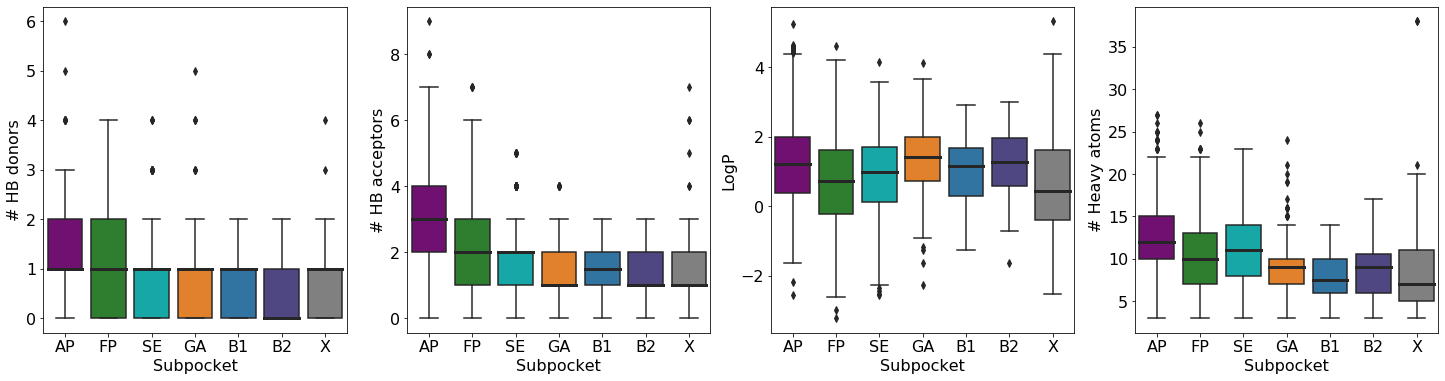

In [45]:
plot_fragment_descriptors(descriptors)

In [46]:
descriptors.groupby('subpocket')['# HB donors'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,1.286996,0.880754,0.0,1.0,1.0,2.0,6.0
B1,42.0,0.595238,0.543679,0.0,0.0,1.0,1.0,2.0
B2,43.0,0.534884,0.701998,0.0,0.0,0.0,1.0,2.0
FP,864.0,1.144676,0.888262,0.0,0.0,1.0,2.0,4.0
GA,306.0,0.820261,0.835904,0.0,0.0,1.0,1.0,5.0
SE,607.0,0.876442,0.812173,0.0,0.0,1.0,1.0,4.0
X,110.0,0.772727,0.725159,0.0,0.0,1.0,1.0,4.0


In [47]:
descriptors.groupby('subpocket')['# HB acceptors'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,3.081614,1.446091,0.0,2.0,3.0,4.0,9.0
B1,42.0,1.380952,0.763573,0.0,1.0,1.5,2.0,3.0
B2,43.0,1.348837,0.783269,0.0,1.0,1.0,2.0,3.0
FP,864.0,1.958333,1.270259,0.0,1.0,2.0,3.0,7.0
GA,306.0,1.500000,0.927715,0.0,1.0,1.0,2.0,4.0
SE,607.0,1.751236,1.060416,0.0,1.0,2.0,2.0,5.0
X,110.0,1.454545,1.324687,0.0,1.0,1.0,2.0,7.0


In [48]:
descriptors.groupby('subpocket')['LogP'].describe().sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
X,110.0,0.637483,1.481660,-2.5223,-0.404825,0.43055,1.616925,5.30610
FP,864.0,0.678346,1.315180,-3.2074,-0.216122,0.72930,1.611725,4.60112
SE,607.0,0.878808,1.190076,-2.5398,0.113200,0.98540,1.703800,4.13230
B1,42.0,1.073996,1.028205,-1.2485,0.294535,1.15670,1.683875,2.90130
AP,1115.0,1.255176,1.169405,-2.5461,0.392100,1.20420,1.990235,5.23640
B2,43.0,1.234849,0.926753,-1.6339,0.593900,1.27960,1.947360,3.00630
GA,306.0,1.341928,0.994495,-2.2714,0.730022,1.40790,1.991490,4.11040


In [49]:
descriptors.groupby('subpocket')['# Heavy atoms'].describe()

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1115.0,12.596413,4.004529,3.0,10.0,12.0,15.0,27.0
B1,42.0,8.071429,2.982820,3.0,6.0,7.5,10.0,14.0
B2,43.0,8.813953,3.560737,3.0,6.0,9.0,10.5,17.0
FP,864.0,10.539352,4.279984,3.0,7.0,10.0,13.0,26.0
GA,306.0,8.908497,3.182657,3.0,7.0,9.0,10.0,24.0
SE,607.0,10.859967,4.072588,3.0,8.0,11.0,14.0,23.0
X,110.0,8.736364,5.885260,3.0,5.0,7.0,11.0,38.0


## Fragment similarity by subpockets

1. Group and deduplicate all fragments by subpocket.
2. Calculate similarities for all pairwise fragment combinations within subpockets.

In [50]:
similarities_per_subpocket = fragment_similarity_per_subpocket(fragment_library_concat)
similarities_per_subpocket.head()

,similarity,subpocket
0,0.104987,AP
1,0.108247,AP
2,0.059072,AP
3,0.198225,AP
4,0.170306,AP


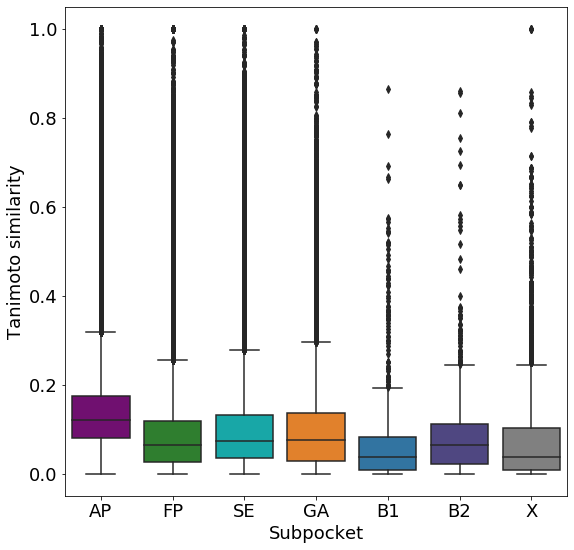

In [51]:
plot_fragment_similarity(similarities_per_subpocket, 'Subpocket')

In [52]:
similarities_per_subpocket.groupby('subpocket', sort=False).mean()

,similarity
subpocket,
AP,0.139290
FP,0.089188
SE,0.102719
GA,0.104821
B1,0.074256
B2,0.088506
X,0.077704


## Fragment similarity by kinase group

1. Group and deduplicate all fragments by kinase group and subpocket (excluding pool X).
2. Calculate similarities for all pairwise fragment combinations within kinase groups and subpockets (excluding X).
4. Calculate total distribution across all kinase groups (i.e. get all similarities by kinase groups and subpockets for the new kinase group 'Total').

In [53]:
similarities_per_kinase_group = fragment_similarity_per_kinase_group(fragment_library_concat_wo_x)
similarities_per_kinase_group.head()

,similarity,group,subpocket
0,0.530864,AGC,AP
1,0.527607,AGC,AP
2,0.464865,AGC,AP
3,0.643411,AGC,AP
4,0.166065,AGC,AP


In [54]:
similarities_per_kinase_group.groupby('group').size()

group
AGC        7666
CAMK      53287
CK1         986
CMGC     148712
Other     22433
STE        5844
TK       135443
TKL       10476
Total    384847
dtype: int64

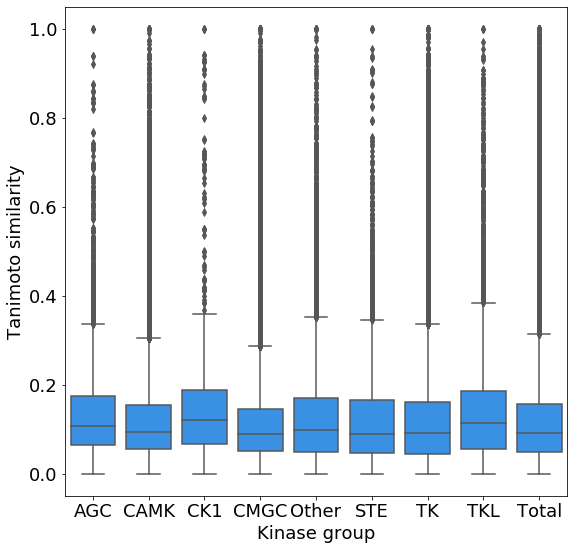

In [55]:
plot_fragment_similarity(similarities_per_kinase_group, 'Kinase group')

In [56]:
similarities_per_kinase_group.groupby('group', sort=False).mean()

,similarity
group,
AGC,0.134660
CAMK,0.119845
CK1,0.160031
CMGC,0.111484
Other,0.126572
STE,0.123428
TK,0.119585
TKL,0.137651
Total,0.117852
